## RAG

RAG stands for **Retrieval-Augmented Generation**. It is a framework that combines the strengths of **retrieval-based systems** and **generative models** to improve the quality and relevance of responses in natural language tasks.

## Purpose

Create RAG application for question answering over a document. These include extracting information, retrieving the relevant context, and utilizing this context to generate accurate results.

<img src='https://miro.medium.com/v2/resize:fit:1100/format:webp/0*hikPIs0EQ1CJ4qrz' width=500>


Typical RAG Application

Step 1: extract information from this document.

Step 2: break the document into smaller chunks, to fit into LLM context windows.

Step 3: two strategies to save documents for future retrieval:
- store the text as-is for keyword based retrieval.
- convert text into vector embeddings, for more efficient retrieval.

Step 4: save this to a relevant database.

Step 5: obtain relevant chunks based on user inputs.

Step 6: incorporate relevant document chunks as part of LLM context, for generating the output.

`Note:` 
- Steps 1 - 4 are referred to as the indexing pipeline, wherein documents are indexed in a database offline, prior to user interactions. 
- Steps 5 - 6 happen in real-time as the user is querying the application.


In [ ]:
import requests
import fitz # PyMuPDF
import io

url = "https://s2.q4cdn.com/299287126/files/doc_financials/2023/q1/Q1-2023-Amazon-Earnings-Release.pdf"
request = requests.get(url)
# request.content

In [44]:
filestream = io.BytesIO(request.content)
file = fitz.open(stream=filestream, filetype='pdf')
page_content = [page.get_text() for page in file]
page_content

['AMAZON.COM ANNOUNCES FIRST QUARTER RESULTS\nSEATTLE—(BUSINESS WIRE) April 27, 2023—Amazon.com, Inc. (NASDAQ: AMZN) today announced financial results \nfor its first quarter ended March 31, 2023. \n•\nNet sales increased 9% to $127.4 billion in the first quarter, compared with $116.4 billion in first quarter 2022.\nExcluding the $2.4 billion unfavorable impact from year-over-year changes in foreign exchange rates throughout the\nquarter, net sales increased 11% compared with first quarter 2022.\n•\nNorth America segment sales increased 11% year-over-year to $76.9 billion.\n•\nInternational segment sales increased 1% year-over-year to $29.1 billion, or increased 9% excluding changes\nin foreign exchange rates.\n•\nAWS segment sales increased 16% year-over-year to $21.4 billion.\n•\nOperating income increased to $4.8 billion in the first quarter, compared with $3.7 billion in first quarter 2022. First\nquarter 2023 operating income includes approximately $0.5 billion of charges related 

In [45]:
text = ''.join(page_content)
text

'AMAZON.COM ANNOUNCES FIRST QUARTER RESULTS\nSEATTLE—(BUSINESS WIRE) April 27, 2023—Amazon.com, Inc. (NASDAQ: AMZN) today announced financial results \nfor its first quarter ended March 31, 2023. \n•\nNet sales increased 9% to $127.4 billion in the first quarter, compared with $116.4 billion in first quarter 2022.\nExcluding the $2.4 billion unfavorable impact from year-over-year changes in foreign exchange rates throughout the\nquarter, net sales increased 11% compared with first quarter 2022.\n•\nNorth America segment sales increased 11% year-over-year to $76.9 billion.\n•\nInternational segment sales increased 1% year-over-year to $29.1 billion, or increased 9% excluding changes\nin foreign exchange rates.\n•\nAWS segment sales increased 16% year-over-year to $21.4 billion.\n•\nOperating income increased to $4.8 billion in the first quarter, compared with $3.7 billion in first quarter 2022. First\nquarter 2023 operating income includes approximately $0.5 billion of charges related t

## Chunking Data

LLMs typically have a token limit. Chunking involves dividing a lengthy text into smaller sections that an LLM can process more efficiently.

These chunks should be of standard size (at minimum) containing answers to common questions. This is because sometimes the question have answers at multiple locations within the document. We would ideally want to capture all disparate parts of the document(s) containing the answers, link them together, and pass to an LLM for answering based on these filtered and concatenated document chunks.

<img src='https://miro.medium.com/v2/resize:fit:1100/format:webp/0*Scnotjdxjfc86ONP' width=500>

The maximum context length is basically the maximum length for concatenating various chunks together, includes: question, context, and answer.

5 levels of chunking:
- **Fixed Size Chunking**: 
    - without considering the content or structure. 
    - simple to implement but may result in chunks that lack coherence or context.
- **Recursive Chunking**: splits the text into smaller chunks using a set of separators (like newlines or spaces) in a hierarchical and iterative manner.
- **Document Based Chunking**: split based on inherent structure, such as markdown formatting, code syntax, or table layouts.

- **Semantic Chunking**: extract semantic meaning from embeddings and assess the semantic relationship between chunks. The core idea is to keep together chunks that are semantic similar.
    - The threshold value (the red line): decide where to split the chunk

<img src='https://miro.medium.com/v2/resize:fit:1100/format:webp/1*C_pdPTvljd-nF2NLC0Bn7g.png' width=400>

- **Agentic Chunking**: use a language model to determine how much and what text should be included in a chunk based on the context. The process involves:
    - Initialize chunks using propositions extracted from text, based on a method that identifies standalone statements.
    - These propositions are then evaluated by an LLM-based agent, which decides whether to add them to an existing chunk or create a new one.

<img src='https://miro.medium.com/v2/resize:fit:1100/format:webp/1*aHXJ5wuWuh1faf_BF7i4og.png' width=500>

`Cosine similarity metric` is used to compare the question with document chunks, to find the top chunks, most likely to contain the answer. It include a keyword metric to weight contexts with certain keywords. 

Ex: weight contexts that contain the words “abstract” or “summary” when asking the question to summarize a document.

### Fixed Size Chunk
split up the texts into chunks, when they reach a provided maximum token length.

In [46]:
import re
import pandas as pd
import tiktoken
tokenizer = tiktoken.get_encoding('cl100k_base')

In [47]:
def split_into_many(text: str, tokenizer: tiktoken.Encoding, max_tokens: int = 1024) -> list:
    """ Function to split a string into many strings of a specified number of tokens """
    #A Split the text into sentences
    #B Get the number of tokens for each sentence
    #C Loop through the sentences and tokens joined together in a tuple
    #D If the number of tokens so far plus the number of tokens in the current sentence is greater than the max number of tokens, then start a new chunk
    #E add the sentence to the chunk and add the number of tokens to the total
    sentences = re.split(r'(?<=\n)(?=[A-Z])', text) #A
    n_tokens = [len(tokenizer.encode(_)) for _ in sentences] #B
    chunks = [['', 0]]
    for sentence, n_token in zip(sentences, n_tokens): #C
        if chunks[-1][1] + n_token > max_tokens: #D
            chunks.append(['', 0])
        #E
        chunks[-1][0] += sentence
        chunks[-1][1] += n_token

    return pd.DataFrame(chunks, columns=['chunk', 'n_token'])

df_chunks = split_into_many(text, tokenizer)
df_chunks

,chunk,n_token
0,AMAZON.COM ANNOUNCES FIRST QUARTER RESULTS\nSE...,1009
1,Continued to delight customers with convenient...,1019
2,Broadridge’s LTX electronic trading platform c...,1005
3,Expanded the Ring lineup with new devices. Rin...,1002
4,Syria. The company turned its fulfillment cent...,878
5,These forward-looking statements are inherentl...,1006
6,"Acquisitions, net of cash acquired, and other\...",1022
7,"Basic\n \n10,171 \n10,250 \nDiluted\n \n10,17...",1005
8,Accumulated other comprehensive income (loss)\...,1014
9,F/X impact -- favorable\n$ \n57 \n$ \n126 \n$ ...,985


## Retrieval Methods

After chunking, store these documents in an appropriate format so that relevant documents can be easily retrieved in response to future queries. There are 2 characteristic methods to retrieve relevant LLM context: keyword based retrieval and vector embeddings based retrieval.

### Keyword Based Retrieval (Sparse Retrievers)

Sort relevant documents by keyword match. Using Term Frequency (TF) and Inverse Document Frequency (IDF).

`TF` measures how often a term appears in a document. The more times a term occurs in a document, the more relevant that document is to the term.

- $TF(t,d) = \frac{\text{number of times term } t \text{ appears in document } d}{\text{total number of terms in document } d}$

`IDF` measures the importance of a term across the entire corpus of documents. Higher importance to terms that are rare in the corpus and lower importance to terms that are common.

- $IDF(t) = \frac{\text{total number of documents}}{\text{number of documents containing term }t}$

The `TF-IDF` score: $TF\text{-}IDF(t,d) = TF(t,d) \times IDF(t)$

Given a query Q containing keywords $q_{i,...,n}$ `Okapi BM25 score` of a document D:

- $score(D,Q)=\sum_{i=1}^{n}IDF(q_i).\frac{f(q_i,D)(k_1+1)}{f(q_i,D)+k_1(1-b+b\frac{|D|}{avgdl})}$

    - $f(q_i, D)$: the number of times $q_i$ occurs in $D$.
    - $k_1, b$: constants.
    - $avgdl$: the average document length.

BM25 characteristic:
- $score \in [0;1] \\
\begin{cases}
    0 \text{ is no keyword overlaps between Query and Document.} \\
    1 \text{  is Document contains all keywords in Query.}
\end{cases}
$
- Uses IDF to weigh the importance of terms across the corpus.
- The term frequency $f(q_i,D)$ is normalized using a saturation function, which prevents the score from increasing linearly with term frequency. This addresses a limitation of basic TF-IDF.
- Document length normalization $\frac{|D|}{avgdl}$ adjusts for the fact that longer documents are more likely to have higher term frequencies.

In [48]:
from rank_bm25 import BM25Okapi
corpus = ["Hello there how are you!",
          "It is quite windy in Boston",
          "How is the weather tomorrow?"]
tokenized_corpus = [doc.split(" ") for doc in corpus]
bm25 = BM25Okapi(tokenized_corpus)
query = "windy day"
tokenized_query = query.split(" ")
doc_scores = bm25.get_scores(tokenized_query)
doc_scores

array([0.        , 0.48362189, 0.        ])

`Note:` the 3rd document is related to the query too (both discuss the weather) so that the 3rd doc should have had a non-zero score.

-> the concept of `semantic similarity` and `vector embeddings` comes in.

`Semantic search` means that the algorithm is intelligent enough to know that '*cowboys*' and the '*wild west*' are similar concepts.

This becomes important for RAG as the user types in a query that is not exactly present in the document.

### Vector Embeddings (Dense Retrievers)

**Bi-encoder**: encode data into high-dimensional vectors and using distance metrics to measure similarity between these vectors, e.g. between user’s query and documents, then return the closest documents vectors.

<img src='https://miro.medium.com/v2/resize:fit:1100/format:webp/0*W-84n-9fbXBCvAFQ' width=500>

In [49]:
texts = ['the boy went to a party',
         'the boy went to a party',
         """We found evidence of bias in our models via running the SEAT (May et al, 2019) and the Winogender (Rudinger et al, 2018) benchmarks. Together, these benchmarks consist of 7 tests that measure whether models contain implicit biases when applied to gendered names, regional names, and some stereotypes. 
         For example, we found that our models more strongly associate (a) European American names with positive sentiment, when compared to African American names, and (b) negative stereotypes with black women."""]

- paid version

In [50]:
# import openai
# openai.api_key = 'API key'
# def get_embedding(text, model="text-embedding-ada-002"):
#     return openai.embeddings.create(input = text, model=model)['data']

# response = get_embedding(texts)
# embeddings = [item['embedding'] for item in response]

- free version

In [51]:
import spacy
nlp = spacy.load("en_core_web_md") # en_core_web_md or en_core_web_trf
def get_embedding(text, model=nlp):
    return model(text).vector

embeddings = [get_embedding(text) for text in texts]
len(embeddings[0])

300

In [56]:
(embeddings[0] != embeddings[1]).sum()

0

cosine similarity between 2 vecs

In [67]:
from scipy.spatial.distance import cosine
print(cosine(embeddings[0], embeddings[1]))
print(cosine(embeddings[0], embeddings[2]))

1.483545730707192e-09
0.4857179978363477


In [64]:
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity([embeddings[0]], [embeddings[1]]))
print(cosine_similarity([embeddings[0]], [embeddings[2]]))

[[1.0000001]]
[[0.514282]]


`Note:` cosine (scipy) + cosine_similarity (sklearn) = 1

### Types of Embedding Models

When selecting an embedding model, consider the *vector dimension*, *average retrieval performance*, and *model size*.

<img src='https://miro.medium.com/v2/resize:fit:1100/format:webp/0*eqfji3JYJZzoltsG' width=500>

1. **Dense Embeddings**: Continuous, high-dimensional vectors with non-zero values throughout, representing rich information, useful in applications like RAG.

2. **Sparse Embeddings**: Representations with mostly zero values, highlighting relevant terms, ideal for handling rare keywords or specialized vocabularies in RAG.

3. **Multi-vector Embeddings**: Models like ColBERT use late interaction, encoding queries and documents independently before interaction.

4. **Challenges with Long Documents**: Sequence length limits in models like BERT require document chunking, which can fragment semantic meaning.

5. **Variable Dimension Embeddings**: Based on Matryoshka Representation Learning (MRL), these allow nested, lower-dimensional representations within original embeddings.

6. **Code Embeddings**: Enable AI features in IDEs, enhancing developer interactions with codebases.

### Vector Embeddings For Finding Relevant Context

In [31]:
prompt = """What was the sales increase for Amazon in the first quarter?"""

- paid ver

In [32]:
# def get_completion(prompt, model="gpt-3.5-turbo"):
#     response = openai.ChatCompletion.create(
#         model=model,
#         temperature=0,
#         messages=[{"role": "user", "content": prompt}]
#     ) #calling OpenAI Completions endpoint
#     return response['choices'][0]['message']['content'].strip()

# get_completion(prompt)

- free ver

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

def get_completion(prompt: str, model_name: str = 'gpt2') -> str:
    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)

    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(
        inputs.input_ids,
        # attention_mask=inputs['attention_mask'],
        max_new_tokens=200,
        pad_token_id=50256,
        num_return_sequences=1)
    return tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

print(get_completion(prompt, 'gpt2'))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


What was the sales increase for Amazon in the first quarter based on the context below?
Context:
```
Net income was $3.2 billion in the first quarter, or $0.31 per diluted share, compared with net loss of $3.8 billion, or
$0.38 per diluted share, in first quarter 2022. All share and per share information for comparable prior year periods
throughout this release have been retroactively adjusted to reflect the 20-for-1 stock split effected on May 27, 2022.
• First quarter 2023 net income includes a pre-tax valuation loss of $0.5 billion included in non-operating
expense from the common stock investment in Rivian Automotive, Inc., compared to a pre-tax valuation loss
of $7.6 billion from the investment in first quarter 2022.
```

###


c:\Users\dangc\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


What was the sales increase for Amazon in the first quarter based on the context below?
Context:
```
Net income was $3.2 billion in the first quarter, or $0.31 per diluted share, compared with net loss of $3.8 billion, or
$0.38 per diluted share, in first quarter 2022. All share and per share information for comparable prior year periods
throughout this release have been retroactively adjusted to reflect the 20-for-1 stock split effected on May 27, 2022.
• First quarter 2023 net income includes a pre-tax valuation loss of $0.5 billion included in non-operating
expense from the common stock investment in Rivian Automotive, Inc., compared to a pre-tax valuation loss
of $7.6 billion from the investment in first quarter 2022.
```
Net income was $3.2 billion in the first quarter, or $0.31 per diluted


`Note:` the above answer maybe not wrong, but it is not the one we are looking for. 

-> It is important to feed the right context to the LLM — in this case, this would be sales performance in Q1 2023. 

We have a choice of the three contexts below to append to the LLM:

In [34]:
context1="""Net sales increased 9% to $127.4 billion in the first quarter, compared with $116.4 billion in first quarter 2022.
Excluding the $2.4 billion unfavorable impact from year-over-year changes in foreign exchange rates throughout the
quarter, net sales increased 11% compared with first quarter 2022.
North America segment sales increased 11% year-over-year to $76.9 billion.
International segment sales increased 1% year-over-year to $29.1 billion, or increased 9% excluding changes
in foreign exchange rates.
AWS segment sales increased 16% year-over-year to $21.4 billion."""

context2="""Operating income increased to $4.8 billion in the first quarter, compared with $3.7 billion in first quarter 2022. First
quarter 2023 operating income includes approximately $0.5 billion of charges related to estimated severance costs.
North America segment operating income was $0.9 billion, compared with operating loss of $1.6 billion in
first quarter 2022.
International segment operating loss was $1.2 billion, compared with operating loss of $1.3 billion in first
quarter 2022.
AWS segment operating income was $5.1 billion, compared with operating income of $6.5 billion in first
quarter 2022.
"""

context3="""Net income was $3.2 billion in the first quarter, or $0.31 per diluted share, compared with net loss of $3.8 billion, or
$0.38 per diluted share, in first quarter 2022. All share and per share information for comparable prior year periods
throughout this release have been retroactively adjusted to reflect the 20-for-1 stock split effected on May 27, 2022.
• First quarter 2023 net income includes a pre-tax valuation loss of $0.5 billion included in non-operating
expense from the common stock investment in Rivian Automotive, Inc., compared to a pre-tax valuation loss
of $7.6 billion from the investment in first quarter 2022."""

In [68]:
for _ in [context1, context2, context3]:
    print(cosine_similarity([get_embedding(prompt)], [get_embedding(_)]))

[[0.85571593]]
[[0.9209387]]
[[0.9801308]]


`Note:` the context3 has the highest cosine similarity with the query embeddings.

-> appending this context to the user input and sending it to the LLM is more likely to give an answer relevant to the user input.

In [ ]:
prompt = f"""What was the sales increase for Amazon in the first quarter based on the context below?
Context:
```
{context3}
```
"""
print(get_completion(prompt, 'gpt2'))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


What was the sales increase for Amazon in the first quarter based on the context below?
Context:
```
Net income was $3.2 billion in the first quarter, or $0.31 per diluted share, compared with net loss of $3.8 billion, or
$0.38 per diluted share, in first quarter 2022. All share and per share information for comparable prior year periods
throughout this release have been retroactively adjusted to reflect the 20-for-1 stock split effected on May 27, 2022.
• First quarter 2023 net income includes a pre-tax valuation loss of $0.5 billion included in non-operating
expense from the common stock investment in Rivian Automotive, Inc., compared to a pre-tax valuation loss
of $7.6 billion from the investment in first quarter 2022.
```

###                  


c:\Users\dangc\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


What was the sales increase for Amazon in the first quarter based on the context below?
Context:
```
Net income was $3.2 billion in the first quarter, or $0.31 per diluted share, compared with net loss of $3.8 billion, or
$0.38 per diluted share, in first quarter 2022. All share and per share information for comparable prior year periods
throughout this release have been retroactively adjusted to reflect the 20-for-1 stock split effected on May 27, 2022.
• First quarter 2023 net income includes a pre-tax valuation loss of $0.5 billion included in non-operating
expense from the common stock investment in Rivian Automotive, Inc., compared to a pre-tax valuation loss
of $7.6 billion from the investment in first quarter 2022.
```
Net income was $3.2 billion in the first quarter, or $0.31 per diluted


`Note:` better reponse with context. However, the highest similarity context is not always the best context.

### Ranking Retrieved Contexts

Before sending retrieved data to a LLM for answer generation, the results must be ranked and filtered for relevance. The order of these results significantly impacts the LLM's output, as the initial context heavily influences its response.

**Approaches for Ranking Results**

1. **Cross-Encoder (described below) Re-Ranking:**  
   - Extract a broader set of results (e.g., top 30 from a vector database).  
   - Use a Cross-Encoder to re-rank these results and select the most relevant subset (e.g., top 10).

2. **Reciprocal Rank Fusion (RRF):**
   - Combines search results from multiple systems by prioritizing higher-ranked elements.  
   - Scoring formula: **1 / (k + rank)**, where *rank* is the element’s position and *k* is a constant (commonly ~60).  
   - Scores from different search systems are summed to create a final ranking.  
   - Strength: Handles variations in scoring scales across different systems and highlights consistently high-ranking elements.  

3. **LLM-Based Ranking and Evaluation:**  
   - Directly leverage an LLM to rank and evaluate results.  
   - Simplifies the process by letting the model determine relevance and priority.

#### Cross-Encoder

<img src='https://miro.medium.com/v2/resize:fit:1100/format:webp/0*h98JJPZ-YSiOWwR1' width=250>

- Two inputs are concatenated into a single sequence with appropriate separators (e.g., `[CLS] Query [SEP] Document [SEP]` for BERT models).  
- The concatenated input is passed through a transformer-based model (e.g., BERT, RoBERTa).  
- The model processes the entire sequence, considering all possible interactions between the query and document.  
- The `[CLS]` token's output embedding (a summary of the interaction) is fed to a classification layer or a regression head to produce a similarity score or relevance label.  
- Scores typically range between 0 and 1 for relevance or as raw logits for ranking purposes.

#### Comparison with Bi-Encoders

| **Aspect**             | **Cross-Encoder**                             | **Bi-Encoder**                          |
|-------------------------|-----------------------------------------------|-----------------------------------------|
| **Interaction**         | Jointly encodes both inputs                  | Encodes inputs independently            |
| **Precision**           | Higher (captures rich interactions)          | Lower                                   |
| **Scalability**         | Lower (expensive for large datasets)         | Higher (pre-computed embeddings)        |
| **Use Case**            | Re-ranking, QA                               | Initial retrieval, large-scale search   |  

### Evaluation of Retrieved Contexts

To assess the quality of search results and determine if changes (e.g., re-ranking) improved relevance, specific metrics are used to evaluate how well the retrieved information aligns with the query.

#### Key Metrics for Evaluation

1. **P@K (Precision at K):**  
   - Measures the proportion of relevant results in the top K retrieved items.  
   - Example: If 2 out of 4 retrieved documents are relevant, P@4 = 2/4 = 0.5.  
   - Limitation: Does not account for the order of results.

2. **AP@K (Average Precision at K):**  
   - Extends P@K by incorporating the order of relevance.  
   - Relevant results appearing earlier in the list contribute more to the score.  
   - Example: AP@4 = (⅓ + ½) / 2 = 0.41, considering relevance positions.  

3. **MAP@K (Mean Average Precision at K):**  
   - Computes the average AP@K across multiple queries or parameters.  
   - Provides a more comprehensive evaluation of the system's overall performance.  

4. **NDCG@K (Normalized Discounted Cumulative Gain at K):**  
   - Evaluates the relevance of ranked results with a focus on position and quality.  
   - Normalizes scores to make them comparable across queries.

#### Relevance Assessment

To calculate these metrics, relevance must be determined:  
1. **LLM-Assisted Assessment:**  
   - Query the LLM for each retrieved document's relevance to the query.  
   - Use specific and context-dependent questions (e.g., *"Does this document pertain to the animal type 'rabbit'?"*).  

2. **Detailed Questions for Relevance:**  
   - Questions should address nuanced parameters, such as whether the rabbit is metaphorical or real.  
   - The granularity of the questions can range from a few to hundreds, depending on the evaluation criteria.

## Augmented Generation

This step is to retrieve the context in real-time based on user input, and use the retrieved context to generate the LLM output.

<img src='https://miro.medium.com/v2/resize:fit:1100/format:webp/0*K0dq67d2R1PbmNMc' width=500>

Step 1: get the embeddings for the question (query).

Step 2: compute pairwise distances between the input query embedding, and context embeddings.

Step 3: append these contexts, ranked by similarity. If the running context length is greater than the maximum context length, the context is truncated.

Step 4: the user query and relevant context are sent to the LLM, for generating the output.

In [ ]:
df_chunks.head()

In [ ]:
def create_context(query: str, df_chunks: pd.DataFrame, max_len: int = 1800) -> str:
    """Create a context for a question by finding the most similar context from the dataframe"""
    #A Get the embeddings for the question
    #B Get the distances from the embeddings
    #C Sort by distance and add the text to the context until the context is too long 
    #D Add the length of the text to the current length
    #E If the context is too long, break
    #F Else add it to the text that is being returned
    #G Return the context
    embedded_query = get_embedding(query)
    df_chunks['embedded_chunk'] = df_chunks['chunk'].apply(lambda chunk: get_embedding(chunk))
    df_chunks['similarity'] = df_chunks['embedded_chunk'].apply(lambda embedded_chunk: cosine_similarity([embedded_chunk], [embedded_query]))

    sum_len = 0
    contexts = []
    for i, row in df_chunks.sort_values('similarity').iterrows():
        if sum_len + row['n_token'] > max_len:
            break
        sum_len += row['n_token']
        contexts.append(row['chunk'])

    return '\n\n###\n\n'.join(contexts)

create_context("What was the sales increase for Amazon in the first quarter", df_chunks)

Use LLM to answer the questions from the created context

In [ ]:
def answer_question(df_chunks: pd.DataFrame, query: str) -> str:
    """Answer a question based on the most similar context from the dataframe texts"""
    context = create_context(query, df_chunks)
    prompt = f"""Answer the question based on the context provided.
    Question:
    ```{query}.```
    Context:
    ```{context}```
    """
    return get_completion(prompt)

answer_question(df_chunks, question='What was the sales increase for Amazon in the first quarter')

In [ ]:
answer_question(df_chunks, question='What was the Comprehensive income (loss) for Amazon for the Three Months Ended March 31, 2022?')

## Challenges and Solutions in the Retrieval Stage

**Challenges:**  
1. **Missed Top-Rank Documents**: Essential documents containing answers may not appear in the top retrieval results.  
2. **Incorrect Specificity**: Retrieved data may lack precision or relevance to the user's specific query.  
3. **Loss of Relevant Context During Reranking**: Relevant documents are retrieved but fail to be included in the final context for answer generation.  

**Proposed Solutions:**  
1. **Query Augmentation**: Enhance queries to improve context relevance using:  
   - Rephrasing.  
   - Hypothetical document embeddings.  
   - Sub-queries for better contextualization (Multi-Query).

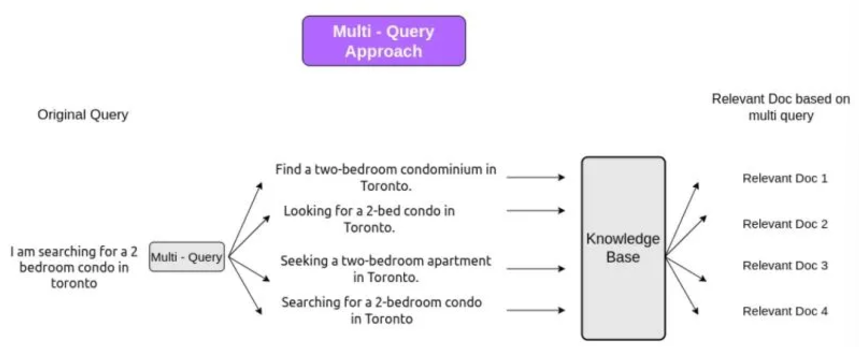

2. **Tweak Retrieval Strategies**: Optimize retrieval accuracy by exploring advanced strategies like:  
   - Small-to-big sentence window retrieval.  
   - Recursive retrieval.  
   - Semantic similarity scoring.
   - Hybrid Search = vector search + full-text search

3. **Hyperparameter Tuning**: Adjust parameters to balance efficiency and retrieval quality:  
   - **Chunk size**: Controls the text block size for retrieval.  
   - **similarity_top_k**: Determines the number of similar chunks retrieved.  

4. **Reranking**: Improve performance by reranking retrieved results before they are processed by the language model, ensuring higher relevance.

<img src='https://miro.medium.com/v2/resize:fit:1100/format:webp/1*Gt9vj9vtaVN9pyc5GcyDGg.png' width=500>

## Evaluation

RAG evaluation involves assessing both the **retrieval** and **generation** components using specific input text. Evaluation methods are broadly divided into two categories based on how the ground truth is provided:  

1. **Ground truth provided by the evaluator/user.**
- **Character-based Evaluation**: Compares the generated output and ground truth character by character to calculate differences.  
- **Word-based Evaluation**: Measures differences word by word between the generated output and the ground truth.  
- **Embedding-based Evaluation**:  
   - Step 1: Generate embeddings for both the output and ground truth using an embedding technique.  
   - Step 2: Measure the similarity or distance (e.g., cosine similarity) between the embeddings.  

2. **Ground truth generated by another LLM (LLM-assisted evaluation).**
- **Mathematical Framework — RAGAS Score**:  
   - A comprehensive framework evaluating retrieval and generation separately for accuracy and relevance.  
- **Experimental Framework — GPT Score**:  
   - Uses GPT-based evaluation on text generation tasks, assessing 22 evaluation aspects across 37 datasets through natural language instructions.

<img src='https://miro.medium.com/v2/resize:fit:1100/format:webp/1*rZ7h3vGX9TXNFa23ID5ubw.png' width=600>

<img src='https://miro.medium.com/v2/resize:fit:1100/format:webp/0*dP8K9L0g9jb1IiW3' width=500>

## Semantic Cache

<img src='https://miro.medium.com/v2/resize:fit:1100/format:webp/0*dcWpVoDAwdClP2lg' width=400>

A semantic caching system aims to identify similar or identical user requests. When a matching request is found, the system retrieves the corresponding information from the cache, reducing the need to fetch it from the original source.

## Reference

[Your First RAG](https://medium.com/emalpha/your-first-rag-5844527aab4a)

[Build RAG Application Using a LLM Running on Local Computer with GPT4All and Langchain](https://medium.com/rahasak/build-rag-application-using-a-llm-running-on-local-computer-with-gpt4all-and-langchain-13b4b8851db8)

[The Many Facets of RAG: From Data to Intelligent Applications](https://levelup.gitconnected.com/the-many-facets-of-rag-from-data-to-intelligent-applications-498fbaf4b1f8)

[A Complete Guide to RAG](https://pub.towardsai.net/a-complete-guide-to-rag-88374d9a4b2c)

[Advanced RAG Techniques: Upgrade Your LLM App Prototype to Production-Ready!](https://levelup.gitconnected.com/advanced-rag-techniques-upgrade-your-llm-app-prototype-to-production-ready-74839342e9c0)